In [1]:
import matplotlib as mpl
import diff_classifier.aws as aws
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.imagej as ij
import diff_classifier.heatmaps as hm

from scipy.spatial import Voronoi
import scipy.stats as stats
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.cm as cm
import os
import os.path as op
import numpy as np
import numpy.ma as ma
import pandas as pd
import boto3

# 4x4 Split

In [2]:
#Splitting section
###############################################################################################
prefix = 'P1_S1_R_0001'
split = 4
remote_folder = "01_18_Experiment/{}".format(prefix.split('_')[0])
local_folder = os.getcwd()
ires = 512
frames = 651
filename = '{}.tif'.format(prefix)
remote_name = remote_folder+'/'+filename
local_name = local_folder+'/'+filename

msd_file = 'msd_{}.csv'.format(prefix)
ft_file = 'features_{}.csv'.format(prefix)

s3 = boto3.client('s3')

names = []
for i in range(0, split):
    for j in range(0, split):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))

In [3]:
try:
    for name in names:
        aws.download_s3(remote_folder+'/'+name, name)
except:
    aws.download_s3(remote_name, local_name)
    names = ij.partition_im(local_name)
    for name in names:
        print("Done with splitting.  Should output file of name {}".format(remote_folder+'/'+name))

In [4]:
#Tracking section
################################################################################################
for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = op.join(local_folder, name)

    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

    test_intensity = ij.mean_intensity(local_im)
    if test_intensity > 500:
        quality = 245
    else:
        quality = 4.5

    if row==3:
        y = 485
    else:
        y = 511

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
             do_median_filtering=True, quality=quality, x=511, y=y, ylo=1, median_intensity=300.0, snr=0.0, 
             linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
             track_displacement=10.0) 

    print("Done with tracking.  Should output file of name {}".format(remote_folder+'/'+outfile))

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpbcvw9qgv.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpzo_96egj.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmprb12l9d6.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_2.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp0yu7fh5n.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_3.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp56m3__2_.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_1_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmplu8j4vf_.py
Done with tracking.  Should output file of name 01

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  ar = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Plotted P1_S1_R_0001 heatmap successfully.
Plotted P1_S1_R_0001 scatterplot successfully.
Plotted P1_S1_R_0001 trajectories successfully.


/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:340: RuntimeWarning: divide by zero encountered in log
  geo_mean = np.nanmean(np.log(y), axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:341: RuntimeWarning: divide by zero encountered in log
  geo_SEM = stats.sem(np.log(y), axis=0, nan_policy='omit')


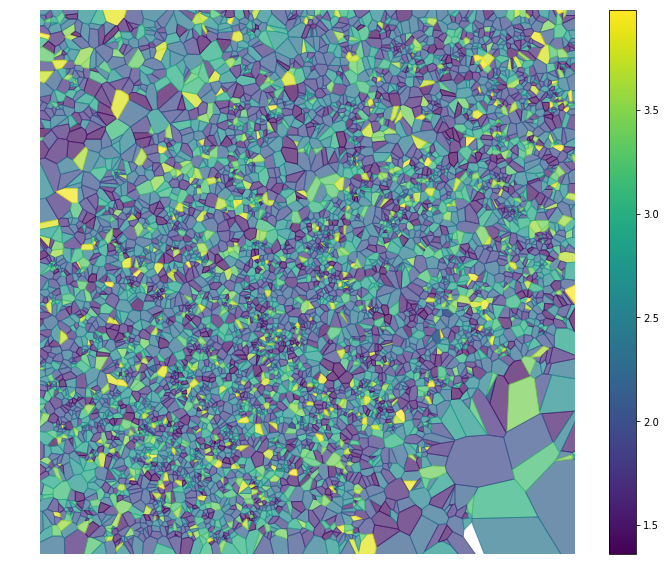

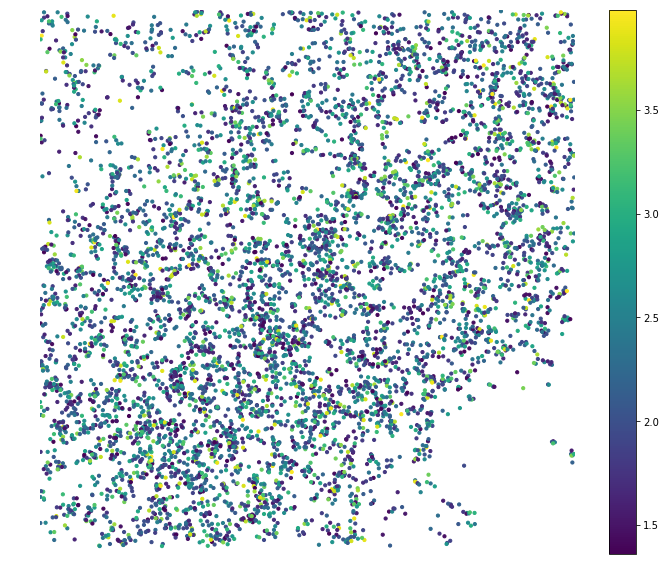

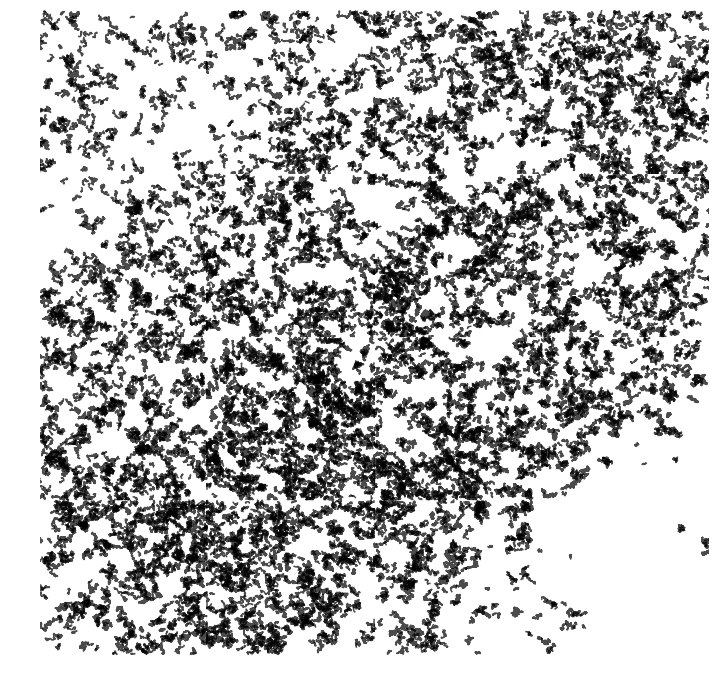

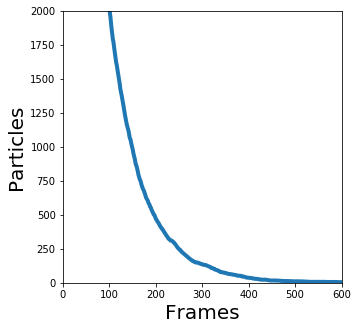

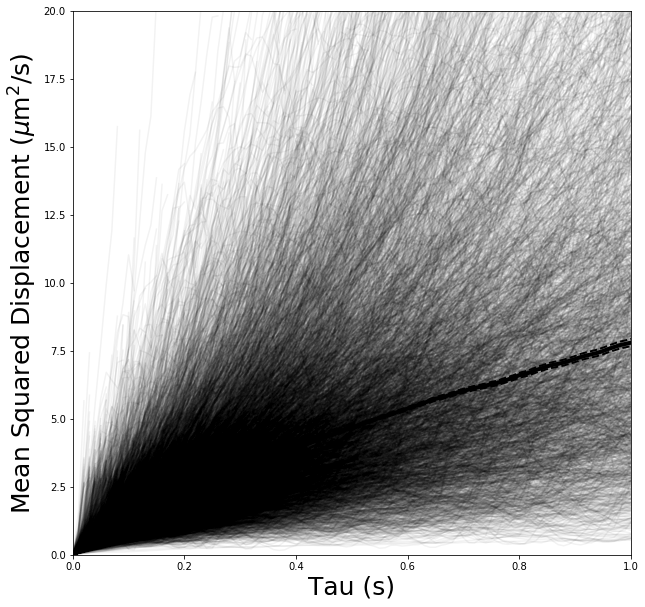

In [5]:
#MSD and features section
#################################################################################################
files_to_big = False
size_limit = 10

for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = name
    file_size_MB = op.getsize(local_im)/1000000
    if file_size_MB > size_limit:
        file_to_big = True

if files_to_big:
    print('One or more of the {} trajectory files exceeds {}MB in size.  Will not continue with MSD calculations.'.format(
          prefix, size_limit))
else:
    counter = 0
    for name in names:
        row = int(name.split('.')[0].split('_')[4])
        col = int(name.split('.')[0].split('_')[5])

        filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
        local_name = local_folder+'/'+filename

        if counter == 0:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            merged = msd.all_msds2(to_add, frames=frames)
        else: 

            if merged.shape[0] > 0:
                to_add = ut.csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires*col
                to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
            else:
                to_add = ut.csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires*col
                to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
                to_add['Track_ID'] = to_add['Track_ID']

            merged = merged.append(msd.all_msds2(to_add, frames=frames))
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
        counter = counter + 1

    merged.to_csv(msd_file)
    merged_ft = ft.calculate_features(merged)
    merged_ft.to_csv(ft_file)

    #Plots          
    features = ('AR', 'D_fit', 'alpha', 'MSD_ratio', 'Track_ID', 'X', 'Y', 'asymmetry1', 'asymmetry2', 'asymmetry3',
                'boundedness', 'efficiency', 'elongation', 'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness')
    vmin = (1.36, 0.015, 0.72, -0.09, 0, 0, 0, 0.5, 0.049, 0.089, 0.0069, 0.65, 0.26, 1.28, 0, 1.66, 0.087, -0.225)
    vmax = (3.98, 2.6, 2.3, 0.015, max(merged_ft['Track_ID']), 2048, 2048, 0.99, 0.415, 0.53,
            0.062, 3.44, 0.75, 1.79, 650, 3.33, 0.52, -0.208)
    die = {'features': features,
           'vmin': vmin,
           'vmax': vmax}
    di = pd.DataFrame(data=die) 
    for i in range(0, 1):
        hm.plot_heatmap(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])
        hm.plot_scatterplot(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])

    hm.plot_trajectories(prefix)

    hm.plot_particles_in_frame(prefix)
    gmean1, gSEM1 = hm.plot_individual_msds(prefix, alpha=0.05)

In [ ]:
# 2x2 Split

In [2]:
#Splitting section
###############################################################################################
prefix = 'P1_S1_R_0001'
split = 2
remote_folder = "01_18_Experiment/{}".format(prefix.split('_')[0])
local_folder = os.getcwd()
ires = 512
frames = 651
filename = '{}.tif'.format(prefix)
remote_name = remote_folder+'/'+filename
local_name = local_folder+'/'+filename

msd_file = 'msd_{}.csv'.format(prefix)
ft_file = 'features_{}.csv'.format(prefix)

s3 = boto3.client('s3')

names = []
for i in range(0, split):
    for j in range(0, split):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))

In [3]:
names = ij.partition_im(local_name, irows=2, icols=2, ires=1024)
for name in names:
    print("Done with splitting.  Should output file of name {}".format(remote_folder+'/'+name))

In [ ]:
#Tracking section
################################################################################################
for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = op.join(local_folder, name)

    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

    test_intensity = ij.mean_intensity(local_im)
    if test_intensity > 500:
        quality = 245
    else:
        quality = 4.5

    if row==3:
        y = 485
    else:
        y = 511

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
             do_median_filtering=True, quality=quality, x=511, y=y, ylo=1, median_intensity=300.0, snr=0.0, 
             linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
             track_displacement=10.0) 

    print("Done with tracking.  Should output file of name {}".format(remote_folder+'/'+outfile))

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpbcvw9qgv.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpzo_96egj.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmprb12l9d6.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_2.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp0yu7fh5n.py
Done with tracking.  Should output file of name 01_18_Experiment/P1/Traj_P1_S1_R_0001_0_3.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp56m3__2_.py


In [ ]:
#MSD and features section
#################################################################################################
files_to_big = False
size_limit = 10

for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = name
    file_size_MB = op.getsize(local_im)/1000000
    if file_size_MB > size_limit:
        file_to_big = True

if files_to_big:
    print('One or more of the {} trajectory files exceeds {}MB in size.  Will not continue with MSD calculations.'.format(
          prefix, size_limit))
else:
    counter = 0
    for name in names:
        row = int(name.split('.')[0].split('_')[4])
        col = int(name.split('.')[0].split('_')[5])

        filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
        local_name = local_folder+'/'+filename

        if counter == 0:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            merged = msd.all_msds2(to_add, frames=frames)
        else: 

            if merged.shape[0] > 0:
                to_add = ut.csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires*col
                to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
            else:
                to_add = ut.csv_to_pd(local_name)
                to_add['X'] = to_add['X'] + ires*col
                to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
                to_add['Track_ID'] = to_add['Track_ID']

            merged = merged.append(msd.all_msds2(to_add, frames=frames))
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
        counter = counter + 1

    merged.to_csv(msd_file)
    aws.upload_s3(msd_file, remote_folder+'/'+msd_file)
    merged_ft = ft.calculate_features(merged)
    merged_ft.to_csv(ft_file)

    aws.upload_s3(ft_file, remote_folder+'/'+ft_file)

    #Plots          
    features = ('AR', 'D_fit', 'alpha', 'MSD_ratio', 'Track_ID', 'X', 'Y', 'asymmetry1', 'asymmetry2', 'asymmetry3',
                'boundedness', 'efficiency', 'elongation', 'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness')
    vmin = (1.36, 0.015, 0.72, -0.09, 0, 0, 0, 0.5, 0.049, 0.089, 0.0069, 0.65, 0.26, 1.28, 0, 1.66, 0.087, -0.225)
    vmax = (3.98, 2.6, 2.3, 0.015, max(merged_ft['Track_ID']), 2048, 2048, 0.99, 0.415, 0.53,
            0.062, 3.44, 0.75, 1.79, 650, 3.33, 0.52, -0.208)
    die = {'features': features,
           'vmin': vmin,
           'vmax': vmax}
    di = pd.DataFrame(data=die) 
    for i in range(0, 1):
        hm.plot_heatmap(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])
        hm.plot_scatterplot(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])

    hm.plot_trajectories(prefix)

    hm.plot_particles_in_frame(prefix)
    gmean1, gSEM1 = hm.plot_individual_msds(prefix, alpha=0.05)